## Basics


In [ ]:
# imports
import numpy as np

import commstools.plotting as plotting
from commstools import set_backend, get_backend
from commstools.dsp.filtering import rrc_taps
from commstools.dsp.sequences import prbs
from commstools.waveforms import ook
import time

t1 = time.time()

set_backend("jax")


Let's start with generating a bit sequence which will represent the data we want to transmit.

In [22]:
# Generate a Pseudo-Random Binary Sequence (PRBS)
bits = prbs(length=2**21, order=31, seed=0x30F1CA55)

print("First Generated 20 bits:", bits[:20])
print("Mean value: ", bits.mean())


First Generated 20 bits: [1 0 1 0 1 0 1 0 0 1 0 1 0 0 1 1 1 0 0 0]
Mean value:  0.53333235


Let's define base system parameters and map the bits to an OOK signal.

In [13]:
# Define system parameters
symbol_rate = 50e6
sampling_rate = 400e6
sps = int(sampling_rate / symbol_rate)
rrc_rolloff = 0.7

sig_impulse = ook(bits, sampling_rate=sampling_rate, sps=sps, pulse_shape="none")

# sig_impulse.plot_signal(
#     num_symbols=20, show=True, title="Expanded Bit Sequence (20 symbols)"
# )


Now, let's pulse shape the signal to get the actual waveform.

In [14]:
# Boxcar (rectangular) pulse shaping
sig_boxcar = ook(bits, sampling_rate=sampling_rate, sps=sps, pulse_shape="boxcar")

# sig_boxcar.plot_signal(
#     num_symbols=20, show=True, title="Boxcar Pulse Shaping (20 symbols)"
# )
# sig_boxcar.plot_psd(show=True, title="Spectrum")


In [15]:
# RRC pulse shaping
sig_rrc = ook(
    bits,
    sampling_rate=sampling_rate,
    sps=sps,
    pulse_shape="rrc",
    filter_span=18,
    rrc_rolloff=rrc_rolloff,
)

# sig_rrc.plot_signal(num_symbols=20, show=True, title="RRC Pulse Shaping (20 symbols)")
# sig_rrc.plot_psd(show=True, title="Spectrum")


Let's investigate the RRC filter we applied.

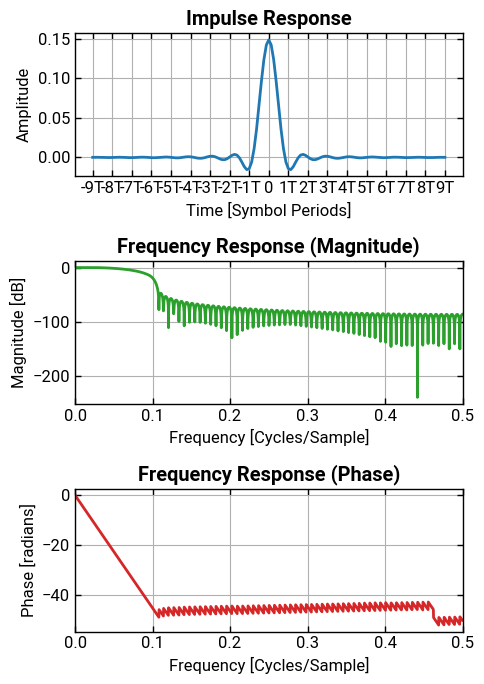

In [16]:
# Create the same RRC filter
rrc_filter = rrc_taps(sps=sps, rolloff=rrc_rolloff, span=18)

# Plot the filter response
plotting.filter_response(rrc_filter, sps, show=True)


Let's add some noise to the signal for naive representation of distorted signal on the receiver.

In [17]:
sig_received = sig_rrc.update(
    sig_rrc.samples + 0.2 * np.random.randn(*sig_rrc.samples.shape)
)

# sig_received.plot_signal(
#     num_symbols=20, show=True, title="Received Waveform (20 symbols)"
# )
# sig_received.plot_psd(show=True, title="Spectrum")


Now we can check what happens on the receiver side.
As the pulse shape is RRC, we need to use a matched filter with the same RRC shape at the receiver.

In [18]:
sig_matchedfilt = sig_received.matched_filter(
    pulse_taps=rrc_filter, taps_normalization="unity_gain", normalize_output=False
)

# sig_matchedfilt.plot_signal(
#     num_symbols=20, show=True, title="Waveform after Matched Filtering (20 symbols)"
# )
# sig_matchedfilt.plot_psd(show=True, title="Spectrum")


In [19]:
# sig_received.plot_eye(plot_type="hist", show=True, cmap="inferno")
# sig_matchedfilt.plot_eye(plot_type="hist", show=True, cmap="inferno")


In [20]:
print("Total time: ", time.time() - t1)


Total time:  1.3204677104949951
